In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
# --- Cell 1: Load Dataset and Initial Cleaning ---


# Load the dataset
data = pd.read_csv('dataset.csv')

# Drop unnecessary columns
cols_to_drop = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'Unnamed: 83', 'gcs_unable_apache']
data.drop(columns=cols_to_drop, inplace=True)

# **Step 1: Replace "Undefined diagnoses" with "Undefined Diagnoses" in 'apache_2_bodysystem'**
# This ensures consistency in category naming
data['apache_2_bodysystem'] = data['apache_2_bodysystem'].replace('Undefined diagnoses', 'Undefined Diagnoses')

# Save 'apache_4a_hospital_death_prob' and 'apache_4a_icu_death_prob' in a separate DataFrame
apache_probs = data[['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']].copy()

# Drop these columns from the main dataset
data.drop(columns=['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], inplace=True)

# Display the first few rows to verify
print("Data after dropping unnecessary columns, replacing category names, and saving Apache probabilities:")
print(data.head())


Data after dropping unnecessary columns, replacing category names, and saving Apache probabilities:
    age    bmi  elective_surgery  ethnicity gender  height  \
0  68.0  22.73               0.0  Caucasian      M   180.3   
1  77.0  27.42               0.0  Caucasian      F   160.0   
2  25.0  31.95               0.0  Caucasian      F   172.7   
3  81.0  22.64               1.0  Caucasian      F   165.1   
4  19.0    NaN               0.0  Caucasian      M   188.0   

            icu_admit_source icu_stay_type      icu_type  pre_icu_los_days  \
0                      Floor         admit         CTICU          0.541667   
1                      Floor         admit  Med-Surg ICU          0.927778   
2       Accident & Emergency         admit  Med-Surg ICU          0.000694   
3  Operating Room / Recovery         admit         CTICU          0.000694   
4       Accident & Emergency         admit  Med-Surg ICU          0.073611   

   ...  cirrhosis  diabetes_mellitus  hepatic_failure  imm

In [3]:
# Drop any rows that have missing values
data.dropna(inplace=True)


print(f"\nData shape before dropping missing values: {data.shape}")
print(f"Data shape after dropping missing values: {data.shape}")


Data shape before dropping missing values: (57692, 77)
Data shape after dropping missing values: (57692, 77)


In [4]:
# Handle comorbidity variables
comorbidity_vars = [
    'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
    'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis'
]

# Ensure comorbidity variables are integers
data[comorbidity_vars] = data[comorbidity_vars].astype(int)

# Compute comorbidity count
data['comorbidity_count'] = data[comorbidity_vars].sum(axis=1)

# Handle GCS (Glasgow Coma Scale) variables
gcs_vars = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']

# Convert GCS variables to numeric if not already
data[gcs_vars] = data[gcs_vars].apply(pd.to_numeric)

# Compute GCS total
data['gcs_total'] = data[gcs_vars].sum(axis=1)

# Re-express categorical variables by combining certain categories

# Ethnicity: Combine 'Asian', 'Native American', 'Other/Unknown' into 'Other'
ethnicities_to_combine = ['Asian', 'Native American', 'Other/Unknown']
data['ethnicity'] = data['ethnicity'].apply(
    lambda x: x if x not in ethnicities_to_combine else 'Other'
)

# ICU Admit Source: Combine 'Other ICU' into 'Other'
icu_admit_sources_to_combine = ['Other ICU']
data['icu_admit_source'] = data['icu_admit_source'].apply(
    lambda x: x if x not in icu_admit_sources_to_combine else 'Other'
)

# ICU Type: Combine 'SICU', 'CTICU', 'CSICU' into 'Other'
icu_types_to_combine = ['SICU', 'CTICU', 'CSICU']
data['icu_type'] = data['icu_type'].apply(
    lambda x: x if x not in icu_types_to_combine else 'Other'
)

# APACHE 3J Bodysystem: Combine specific categories into 'Other'
apache_3j_bodysystem_to_combine = [
    'Gynecological',
    'Musculoskeletal/Skin',
    'Hematological',
    'Genitourinary',
    'Trauma',
    'Metabolic'
]
data['apache_3j_bodysystem'] = data['apache_3j_bodysystem'].apply(
    lambda x: x if x not in apache_3j_bodysystem_to_combine else 'Other'
)

# Drop individual comorbidity and GCS columns since we have the totals
data.drop(columns=comorbidity_vars + gcs_vars, inplace=True)

# Display the first few rows to verify feature engineering
print("Data after Feature Engineering:")
print(data.head())


Data after Feature Engineering:
     age        bmi  elective_surgery  ethnicity gender  height  \
0   68.0  22.730000               0.0  Caucasian      M   180.3   
1   77.0  27.420000               0.0  Caucasian      F   160.0   
5   67.0  27.560000               0.0  Caucasian      M   190.5   
10  72.0  28.257052               1.0   Hispanic      F   154.9   
17  46.0  25.845717               0.0   Hispanic      M   167.6   

             icu_admit_source icu_stay_type      icu_type  pre_icu_los_days  \
0                       Floor         admit         Other          0.541667   
1                       Floor         admit  Med-Surg ICU          0.927778   
5        Accident & Emergency         admit  Med-Surg ICU          0.000694   
10  Operating Room / Recovery         admit  Med-Surg ICU          0.004861   
17       Accident & Emergency         admit         Other          0.000000   

    ...  h1_sysbp_noninvasive_min  d1_glucose_max  d1_glucose_min  \
0   ...              

In [5]:
# --- Cell 6: Display Numerical and Categorical Features Separately ---

# **Step 1: Define Categorical Features Before Encoding**
# It's crucial to define which features are categorical based on your understanding of the data.
# Adjust this list based on your dataset's actual categorical features.

categorical_features = [
    'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type',
    'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem'
]

# **Step 2: Identify Numerical Features (Excluding the Target Variable)**
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
if 'hospital_death' in numerical_features:
    numerical_features.remove('hospital_death')

# **Step 3: Differentiate Between Binary and Continuous Numerical Features**
# Binary categorical features are those categorical features with exactly two unique values
binary_columns = [col for col in categorical_features if data[col].nunique() == 2]
# Continuous numerical features are the remaining numerical features not in binary_columns
continuous_numerical_features = [col for col in numerical_features if col not in binary_columns]

# **Step 4: Print Feature Lists**
print("Continuous Numerical Features:")
print(continuous_numerical_features)

print("\nCategorical Features:")
print(categorical_features)

print("\nBinary Categorical Features:")
print(binary_columns)

# **Step 5: Summary Statistics for Continuous Numerical Features**
if continuous_numerical_features:
    print("\nSummary Statistics of Continuous Numerical Features:")
    print(data[continuous_numerical_features].describe())
else:
    print("\nNo Continuous Numerical Features to display.")


Continuous Numerical Features:
['age', 'bmi', 'elective_surgery', 'height', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sy

In [6]:
# --- Cell 10: Encode Categorical Variables Appropriately ---

from sklearn.preprocessing import LabelEncoder

# Identify categorical features (predefined)
print("Categorical Features to Encode:")
print(categorical_features)

# Initialize LabelEncoders for each categorical column
label_encoders = {}

# Apply Label Encoding to all categorical features
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Save the encoder for future use (e.g., during inference)

# Verify that all categorical features have been encoded
print("\nData Types After Label Encoding:")
print(data.dtypes)


Categorical Features to Encode:
['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem']

Data Types After Label Encoding:
age                     float64
bmi                     float64
elective_surgery        float64
ethnicity                 int64
gender                    int64
                         ...   
apache_3j_bodysystem      int64
apache_2_bodysystem       int64
hospital_death          float64
comorbidity_count         int64
gcs_total               float64
Length: 68, dtype: object


In [7]:
# --- Cell 11: Label Encoding Explanation and Mappings ---

from sklearn.preprocessing import LabelEncoder

# **Step 1: Explanation of Label Encoding**
print("""
**Label Encoding Explained:**

Label Encoding is a technique used to convert categorical variables into numerical form so that machine learning algorithms can process them.
Each unique category in a feature is assigned an integer value.

**Example:**
For a feature 'gender' with categories ['Male', 'Female'], Label Encoding might assign:
- 'Male' -> 0
- 'Female' -> 1

**Important Note:**
Label Encoding does not preserve any ordinal relationship unless the categories inherently have one.
For purely nominal categorical variables, One-Hot Encoding is often preferred to avoid introducing unintended ordinal relationships.

Below, we'll display the mapping of each categorical feature from its original categories to the encoded numerical values.
""")

# **Step 2: Display Label Encoding Mappings for Each Categorical Feature**
for col, le in label_encoders.items():
    print(f"\n**Feature: {col}**")
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    for category, code in mapping.items():
        print(f"  {code}: {category}")



**Label Encoding Explained:**

Label Encoding is a technique used to convert categorical variables into numerical form so that machine learning algorithms can process them.
Each unique category in a feature is assigned an integer value.

**Example:**
For a feature 'gender' with categories ['Male', 'Female'], Label Encoding might assign:
- 'Male' -> 0
- 'Female' -> 1

**Important Note:**
Label Encoding does not preserve any ordinal relationship unless the categories inherently have one.
For purely nominal categorical variables, One-Hot Encoding is often preferred to avoid introducing unintended ordinal relationships.

Below, we'll display the mapping of each categorical feature from its original categories to the encoded numerical values.


**Feature: ethnicity**
  0: African American
  1: Caucasian
  2: Hispanic
  3: Other

**Feature: gender**
  0: F
  1: M

**Feature: icu_admit_source**
  0: Accident & Emergency
  1: Floor
  2: Operating Room / Recovery
  3: Other
  4: Other Hospital

In [8]:
# --- Final Cell: Inspect Final Processed Dataset Features ---

# **Step 1: Display the List of Final Features**
print("Final Processed Dataset Columns:")
print(data.columns.tolist())

# **Step 2: Show the First Few Rows of the Processed Dataset**
print("\nFirst 5 Rows of the Final Processed Dataset:")
display(data.head())

# **Step 3: Provide a Summary of the DataFrame**
print("\nSummary of the Final Processed Dataset:")
data.info()


Final Processed Dataset Columns:
['age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max

,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,...,h1_sysbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_potassium_max,d1_potassium_min,apache_3j_bodysystem,apache_2_bodysystem,hospital_death,comorbidity_count,gcs_total
0,68.0,22.730000,0.0,1,1,180.3,1,0,5,0.541667,...,115.0,168.0,109.0,4.0,3.4,5,0,0.0,1,13.0
1,77.0,27.420000,0.0,1,0,160.0,1,0,3,0.927778,...,71.0,145.0,128.0,4.2,3.8,4,6,0.0,1,5.0
5,67.0,27.560000,0.0,1,1,190.5,0,0,3,0.000694,...,143.0,156.0,125.0,3.9,3.7,2,4,0.0,1,15.0
10,72.0,28.257052,1.0,2,0,154.9,2,0,3,0.004861,...,114.0,158.0,133.0,4.2,4.2,4,6,0.0,1,15.0
17,46.0,25.845717,0.0,2,1,167.6,0,0,5,0.000000,...,115.0,143.0,143.0,4.9,4.9,4,6,0.0,0,6.0



Summary of the Final Processed Dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 57692 entries, 0 to 85687
Data columns (total 68 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        57692 non-null  float64
 1   bmi                        57692 non-null  float64
 2   elective_surgery           57692 non-null  float64
 3   ethnicity                  57692 non-null  int64  
 4   gender                     57692 non-null  int64  
 5   height                     57692 non-null  float64
 6   icu_admit_source           57692 non-null  int64  
 7   icu_stay_type              57692 non-null  int64  
 8   icu_type                   57692 non-null  int64  
 9   pre_icu_los_days           57692 non-null  float64
 10  weight                     57692 non-null  float64
 11  apache_2_diagnosis         57692 non-null  float64
 12  apache_3j_diagnosis        57692 non-null  float64
 13  apache_pos

## autogluon

In [9]:
!pip install flaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 4.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Features shape: (57692, 67)
Target shape: (57692,)
Training features shape: (46153, 67)
Testing features shape: (11539, 67)

Applying SMOTE to handle class imbalance...
After SMOTE, training features shape: (84440, 67)
After SMOTE, training target distribution:
hospital_death
0.0    42220
1.0    42220
Name: count, dtype: int64

Training FLAML AutoML model...


INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


FLAML AutoML training completed.

Best Model: <flaml.automl.model.LGBMEstimator object at 0x7d6ae4e55300>

=== FLAML AutoML Model Evaluation ===
Classification Report with Default Threshold (0.5):
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96     10556
         1.0       0.63      0.27      0.38       983

    accuracy                           0.92     11539
   macro avg       0.78      0.63      0.67     11539
weighted avg       0.91      0.92      0.91     11539

ROC AUC Score: 0.8662

Optimal Threshold for Desired Recall of 90%: 0.00

=== FLAML AutoML Model Evaluation at Optimal Threshold ===
Classification Report:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000     10556
         1.0     0.0852    1.0000    0.1570       983

    accuracy                         0.0852     11539
   macro avg     0.0426    0.5000    0.0785     11539
weighted avg     0.0073    0.0852    0.0134     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


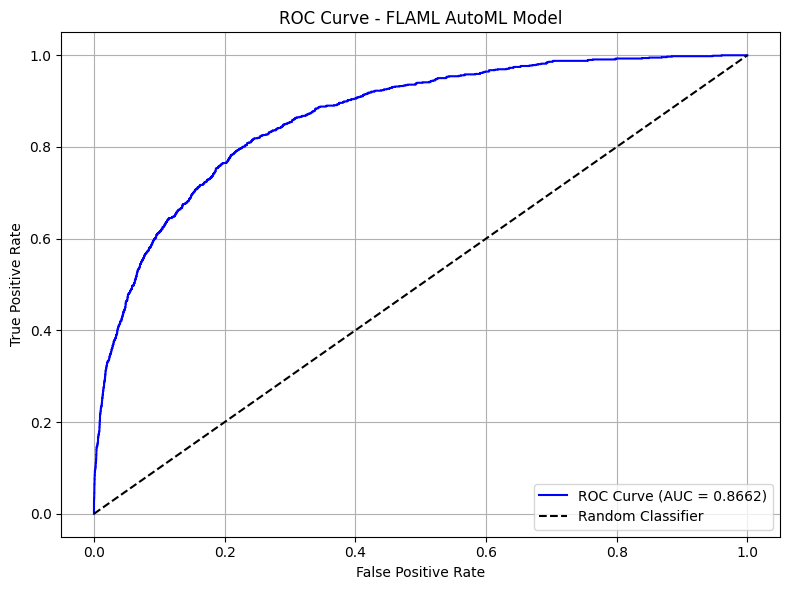

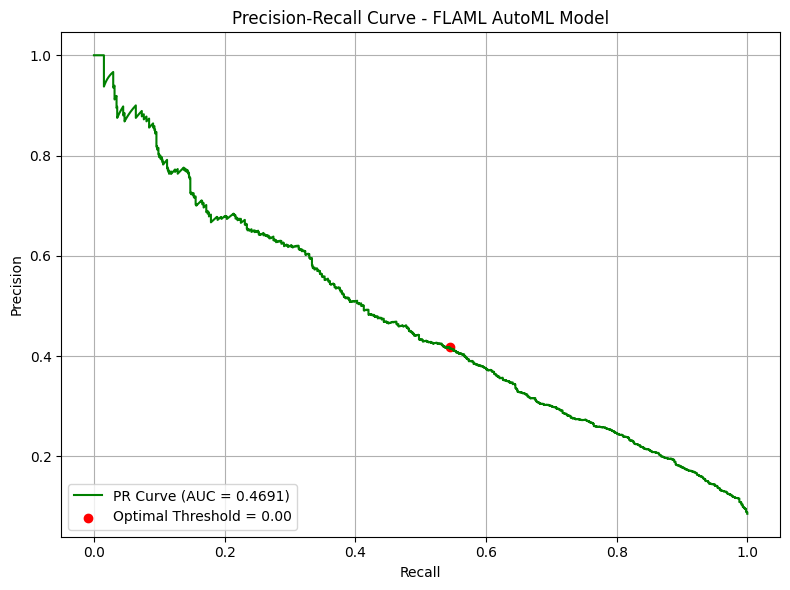

PR AUC Score: 0.4691


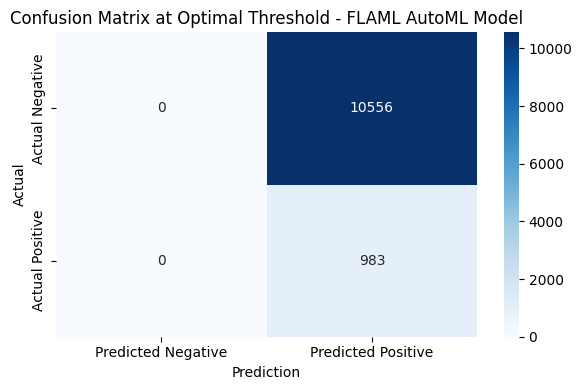

In [10]:
# Cell 1: Complete FLAML AutoML Workflow

# Import necessary libraries
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

X = data.drop(columns=['hospital_death'])
y = data['hospital_death']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")

# Handle class imbalance using SMOTE (if applicable)
if y_train.value_counts().min() / y_train.value_counts().max() < 0.5:
    print("\nApplying SMOTE to handle class imbalance...")
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print(f"After SMOTE, training features shape: {X_train_smote.shape}")
    print(f"After SMOTE, training target distribution:\n{pd.Series(y_train_smote).value_counts()}")
else:
    print("\nClass imbalance is not significant. Proceeding without SMOTE.")
    X_train_smote, y_train_smote = X_train, y_train

# Initialize FLAML AutoML
automl = AutoML()

# Specify FLAML AutoML settings
automl_settings = {
    "time_budget": 300,    # Time budget in seconds (e.g., 5 minutes)
    "metric": 'f1',        # Primary metric to optimize
    "task": 'classification',
    "log_file_name": 'automl_flaml.log',  # Log file
    "verbose": 1,          # Show progress logs
    # "estimator_list": ['lr', 'rf', 'xgboost'],  # Optional: Specify estimators to consider
}

# Train FLAML AutoML model
print("\nTraining FLAML AutoML model...")
automl.fit(X_train=X_train_smote, y_train=y_train_smote, **automl_settings)
print("FLAML AutoML training completed.")

# View the best model
print(f"\nBest Model: {automl.model}")

# Make predictions on the test set
y_pred = automl.predict(X_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]  # Probability estimates for the positive class

# Evaluation with default threshold (0.5)
print("\n=== FLAML AutoML Model Evaluation ===")
print("Classification Report with Default Threshold (0.5):")
print(classification_report(y_test, y_pred))

# Calculate ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Function to find optimal threshold based on desired recall
def find_threshold_for_recall(y_true, y_probs, desired_recall):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    # Iterate through thresholds to find the first threshold where recall >= desired_recall
    for thresh, rec in zip(thresholds, recall):
        if rec >= desired_recall:
            return thresh
    return 0.5  # Default threshold if desired recall not achievable

# Define desired recall
desired_recall = 0.90  # 90% Recall

# Find optimal threshold
optimal_threshold = find_threshold_for_recall(y_test, y_pred_proba, desired_recall)
print(f"\nOptimal Threshold for Desired Recall of {desired_recall*100:.0f}%: {optimal_threshold:.2f}")

# Apply optimal threshold to obtain new predictions
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Classification report with optimal threshold
print("\n=== FLAML AutoML Model Evaluation at Optimal Threshold ===")
print("Classification Report:")
print(classification_report(y_test, y_pred_optimal, digits=4))

# Plot ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - FLAML AutoML Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})', color='green')
plt.scatter(
    recall[np.argmax(2*(precision*recall)/(precision+recall+1e-6))],
    precision[np.argmax(2*(precision*recall)/(precision+recall+1e-6))],
    color='red',
    label=f'Optimal Threshold = {optimal_threshold:.2f}'
)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - FLAML AutoML Model')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"PR AUC Score: {pr_auc:.4f}")

# Plot Confusion Matrix at Optimal Threshold
conf_matrix = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(6,4))
sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Predicted Negative', 'Predicted Positive'],
    yticklabels=['Actual Negative', 'Actual Positive']
)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix at Optimal Threshold - FLAML AutoML Model')
plt.tight_layout()
plt.show()
